# Joint report plots

This notebook (along with `../wavenet/report plots (joint).ipynb`) reproduces the figure in the Solid Earth paper which compares the WaveNet and conditional autoencoder networks together.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from analysis import load_model, load_testdataset, plot_result

In [2]:
# Global constants
DT = 0.002
T_GAIN = 2.5
DX,DZ = 5., 5.
NX,NZ = 128, 128
NREC,NSTEPS = 11, 512

# define gain profile for display
t_gain = np.arange(NSTEPS, dtype=np.float32)**T_GAIN
t_gain = t_gain/np.median(t_gain)
t_gain = t_gain.reshape((1,1,1,NSTEPS))# along NSTEPS
VLIM = 0.7
CLIM = (1500,3600)
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

## Run autoencoder

In [3]:
# check source/ receiver positions
r1 = np.load("../generate_data/gather/layers_2ms_validate/receiver_is.npy")
s1 = np.load("../generate_data/gather/layers_2ms_validate/source_is.npy")
print(r1[5], s1[0:10,0])
r2 = np.load("../generate_data/gather/fault_2ms_r_validate/receiver_is.npy")
print(r1[:,0])
print(r2[:,0])

[64 14] [[64 14]
 [64 14]
 [64 14]
 [64 14]
 [64 14]
 [64 14]
 [64 14]
 [64 14]
 [64 14]
 [64 14]]
[ 14  24  34  44  54  64  74  84  94 104 114]
[ 17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68
  71  74  77  80  83  86  89  92  95  98 101 104 107 110]


In [4]:
# get source locations and indices needed to reproduce wavenet gather

source_is = [3,-4,1] # i.e. we need to run 3 sources to reproduce
extract_is = [[i for i,x in enumerate(r2[:,0]-source_i) if str(x).endswith("4")] for source_i in source_is]
location_is = [[np.argwhere(r1[:,0]==r2[v,0]-source_is[i])[0][0] for v in extract_is[i]] for i in range(len(source_is))]

for i in range(len(source_is)):
    print("source_i:",source_is[i])
    print(extract_is[i])
    print(r2[extract_is[i],0]-source_is[i])
    print(location_is[i])
    print()

source_i: 3
[0, 10, 20, 30]
[ 14  44  74 104]
[0, 3, 6, 9]

source_i: -4
[1, 11, 21, 31]
[ 24  54  84 114]
[1, 4, 7, 10]

source_i: 1
[6, 16, 26]
[34 64 94]
[2, 5, 8]



In [5]:
# Load model and dataset
model, c_dict = load_model("fault_cae", verbose=False)
c_dict["GATHER_SHAPE"] = (1, 11, 512)# only 11 receivers in this one
d = load_testdataset("layers_2ms_validate_ae.bin", N_EXAMPLES=1000, c_dict=c_dict, verbose=False)

Loading model from: server/models/fault_cae/model_03000000.torch
1000 examples
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 

In [6]:
# Get batches of test data
irange = np.arange(1000)
d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
    
inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
source_array = inputs[1].detach().cpu().numpy().copy()
labels_array = labels[0].detach().cpu().numpy().copy()

# hack: add extra sources so we can reproduce the wavenet gather
source_array_shifts = []
for source_i in source_is:
    source_array_shift = source_array.copy()
    source_array_shift[:,0,:,:] += (source_i/NX)# shift the source
    print(source_array_shift[0:5,:,0,0]*NX)
    source_array_shifts.append(source_array_shift)
source_array = np.concatenate(source_array_shifts)
inputs_array = np.concatenate([inputs_array.copy() for _ in range(len(source_is))])

print(source_array.shape)
print(inputs_array.shape)

inputs = [torch.from_numpy(inputs_array.copy()), torch.from_numpy(source_array.copy())]

torch.Size([1000, 1, 128, 128])
torch.Size([1000, 2, 1, 1])
torch.Size([1000, 1, 11, 512])
[[67. 14.]
 [67. 14.]
 [67. 14.]
 [67. 14.]
 [67. 14.]]
[[60. 14.]
 [60. 14.]
 [60. 14.]
 [60. 14.]
 [60. 14.]]
[[65. 14.]
 [65. 14.]
 [65. 14.]
 [65. 14.]
 [65. 14.]]
(3000, 2, 1, 1)
(3000, 1, 128, 128)


In [7]:
# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

outputs_array = outputs[0].detach().cpu().numpy().copy()
print(outputs_array.shape)

# un-normalise velocity
inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]

(3000, 1, 32, 512)


In [8]:
# extract wavenet gather
trace_array = np.zeros(labels_array.shape, dtype=labels_array.dtype)
print(trace_array.shape)
print()

for i in range(len(source_is)):

    partial_traces = outputs_array[i*1000:i*1000+1000,:,extract_is[i],:]
    trace_array[:,:,location_is[i],:]=partial_traces.copy()
    
    print(source_is[i])
    print(extract_is[i])
    print(r2[extract_is[i],0]+source_is[i])
    print(location_is[i])
    print(partial_traces.shape)
    print()
    
np.save("trace_array_ae.npy", trace_array)

(1000, 1, 11, 512)

3
[0, 10, 20, 30]
[ 20  50  80 110]
[0, 3, 6, 9]
(1000, 1, 4, 512)

-4
[1, 11, 21, 31]
[ 16  46  76 106]
[1, 4, 7, 10]
(1000, 1, 4, 512)

1
[6, 16, 26]
[36 66 96]
[2, 5, 8]
(1000, 1, 3, 512)



# QC plots

(400, 0)

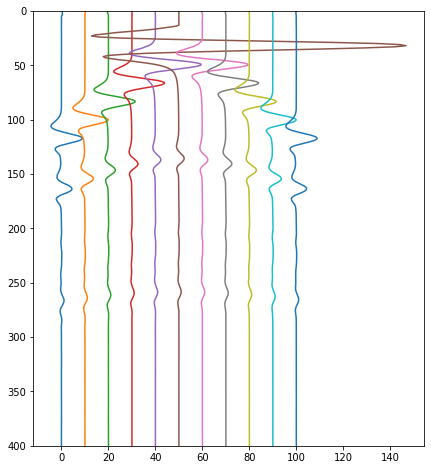

In [9]:
plt.figure(figsize=(7,8))
for irec in range(labels_array.shape[2]):
    plt.plot(trace_array[900,0,irec,:]+10*irec, np.arange(512))
plt.gca().invert_yaxis()
plt.ylim(400,0)

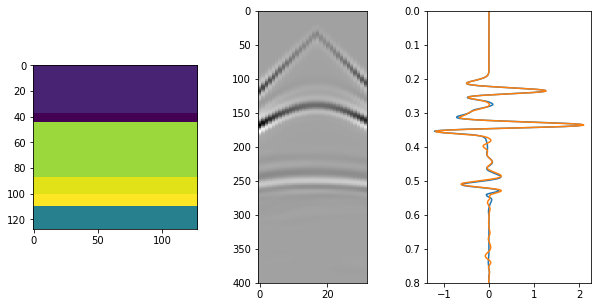

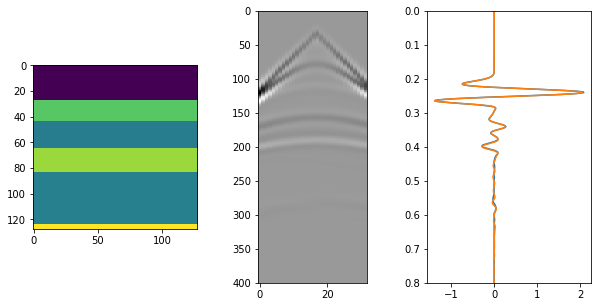

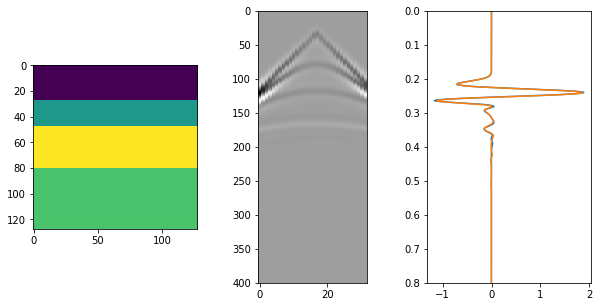

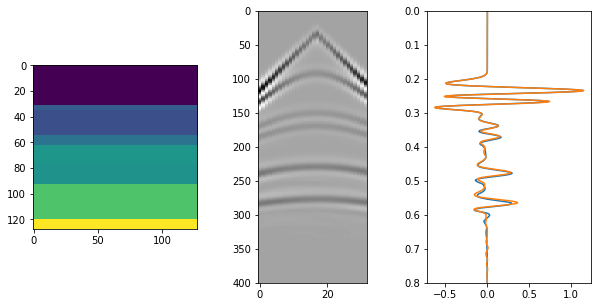

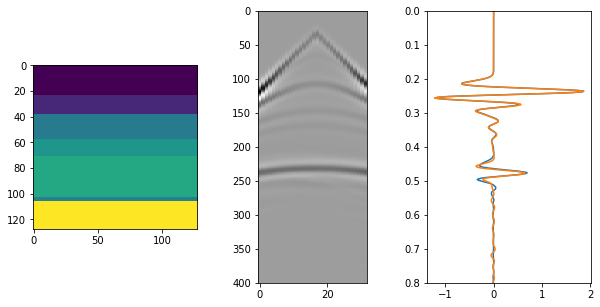

In [10]:
# qc plot
for ib in range(5):
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(inputs_array[ib,0,:,:].T)
    plt.subplot(1,3,2)
    plt.imshow((t_gain*outputs_array)[ib,0,:,:].T, aspect=0.2, cmap="gray_r")
    plt.ylim(400,0)
    plt.subplot(1,3,3)
    plt.plot((t_gain*trace_array)[ib,0,10,:], DT*np.arange(NSTEPS))
    plt.plot((t_gain*labels_array)[ib,0,10,:], DT*np.arange(NSTEPS))
    plt.gca().invert_yaxis()
    plt.ylim(DT*400,0)

(400, 0)

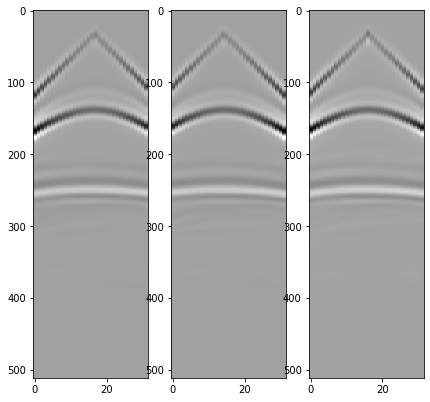

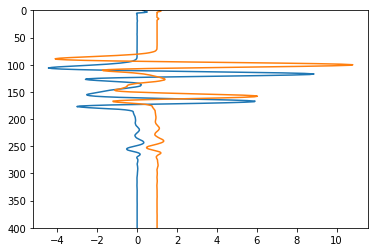

In [12]:
output_1 = outputs_array[0:1000,:,:,:]
output_2 = outputs_array[1000:2000,:,:,:]
output_3 = outputs_array[2000:3000,:,:,:]

plt.figure(figsize=(7,7))
plt.subplot(1,3,1)
plt.imshow((t_gain*output_1)[0,0,:,:].T, aspect=0.2, cmap="gray_r")
plt.subplot(1,3,2)
plt.imshow((t_gain*output_2)[0,0,:,:].T, aspect=0.2, cmap="gray_r")
plt.subplot(1,3,3)
plt.imshow((t_gain*output_3)[0,0,:,:].T, aspect=0.2, cmap="gray_r")

plt.figure()
plt.plot(output_1[0,0,0,:]+0, np.arange(512))
plt.plot(output_2[0,0,1,:]+1, np.arange(512))
plt.gca().invert_yaxis()
plt.ylim(400,0)